# Single qubit: phase estimation
This example shows a one-qubit interference experiment.

In [43]:
import itertools
import jax 

import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.dv import DiscreteVariableState, HGate, RZGate
from squint.ops.noise import BitFlipChannel

In [44]:
circuit = Circuit(backend="pure")

#          ____      ___________      ____
# |0> --- | H | --- | Rz(\phi) | --- | H | ----
#         ----      -----------      ----

circuit.add(DiscreteVariableState(wires=(0,), n=(0,)))
circuit.add(HGate(wires=(0,)))
circuit.add(RZGate(wires=(0,), phi=0.0 * jnp.pi), "phase")
circuit.add(HGate(wires=(0,)))

pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteVariableState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   HGate(wires=(0,)),
│   'phase':
│   RZGate(wires=(0,), phi=weak_f64[]),
│   3:
│   HGate(wires=(0,))
  },
  _backend='pure'
)

In [45]:
pprint(circuit.subscripts)

'a,ab,bc,cd->d'

In [46]:
params, static = eqx.partition(circuit, eqx.is_inexact_array)
get = lambda pytree: jnp.array([pytree.ops["phase"].phi])
sim = circuit.compile(params, static, dim=2, optimize="greedy")

In [47]:
ket = sim.amplitudes.forward(params)
dket = sim.amplitudes.grad(params)
prob = sim.probabilities.forward(params)
dprob = sim.probabilities.grad(params)

print(f"{ket.shape}, {ket.dtype}")
print(f"{prob.shape}, {prob.dtype}")

(2,), complex64
(2,), float32


In [48]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)

def update(phi, params):
    return eqx.tree_at(lambda pytree: pytree.ops["phase"].phi, params, phi)
    
probs = jax.lax.map(lambda phi: sim.probabilities.forward(update(phi, params)), phis)
qfims = jax.lax.map(lambda phi: sim.amplitudes.qfim(get, update(phi, params)), phis)
cfims = jax.lax.map(lambda phi: sim.probabilities.cfim(get, update(phi, params)), phis)


[Text(0.5, 0, 'Phase, $\\varphi$'),
 Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$'),
 (0.0, 1.0500002320923627)]

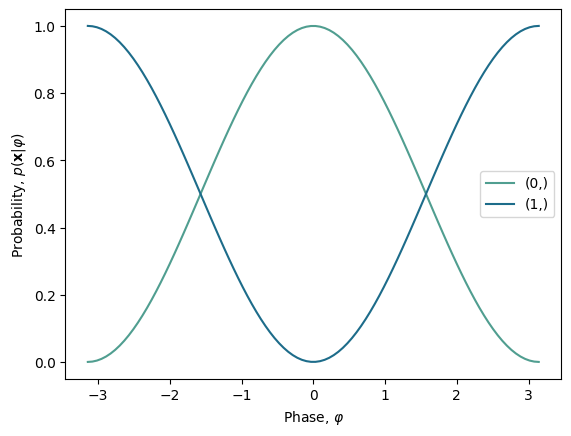

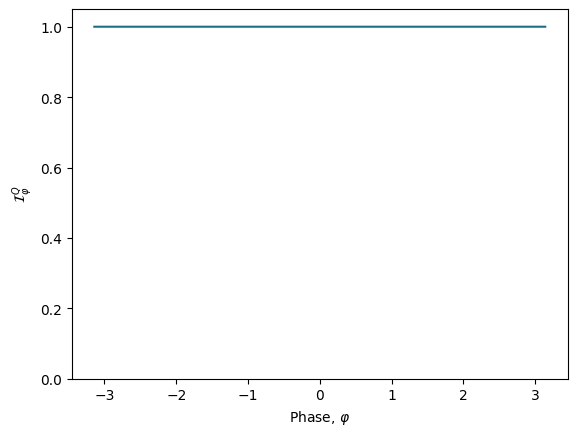

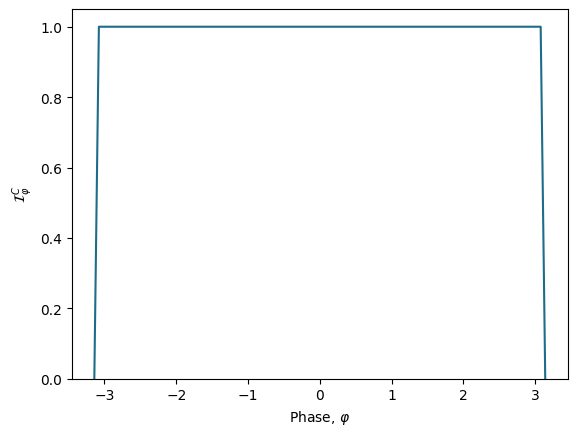

In [49]:
colors = sns.color_palette("crest", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, ax = plt.subplots()
for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    ax.plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
ax.legend()
ax.set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")


fig, ax = plt.subplots()
ax.plot(phis, qfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^Q$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)

fig, ax = plt.subplots()
ax.plot(phis, cfims.squeeze(), color=colors[i])
ax.set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    ylim=[0, 1.05 * jnp.max(cfims)],
)